In [7]:
# ===== Block 11 =====
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iGSaRG2y43GaizViHQEx")
project = rf.workspace("machine-learning-class-eiri5").project("intersection-traffic-piimy")
version = project.version(8)
dataset = version.download("yolov8")
# ===================

loading Roboflow workspace...
loading Roboflow project...


In [1]:
# ===== Block 2 =====
# Imports for working with files, data processing, and model training
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import resnet18

# For visualizing embeddings
from sklearn.manifold import TSNE
# ===================

In [2]:
# ===== Block 3 =====
# Paths to the dataset
dataset_path = "C:\\ML_image_lab\\Intersection-Traffic--8"
output_path = "C:\\ML_image_lab\\intersection_classification"

# Create directories for classification data
categories = ["bicycle", "bus", "car", "motorcycle"]
for category in categories:
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

# Data preparation
def prepare_classification_data(dataset_path, output_path, test_size=0.2, val_size=0.1):
    image_paths = list(Path(dataset_path, "train/images").rglob("*.jpg"))
    labels_path = Path(dataset_path, "train/labels")

    # Create (image, label) pairs
    data = []
    for image_path in image_paths:
        label_path = labels_path / (image_path.stem + ".txt")
        if label_path.exists():
            with label_path.open("r") as f:
                lines = [line.strip().split() for line in f]
                if lines:
                    # Take the first label as the class
                    class_idx = int(lines[0][0])
                    data.append((image_path, categories[class_idx]))

    # Split into train, val, test
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=42)

    # Copy data
    def copy_data(split_data, split_name):
        for image_path, category in split_data:
            dest_path = Path(output_path, split_name, category, image_path.name)
            shutil.copy(image_path, dest_path)

    copy_data(train_data, "train")
    copy_data(val_data, "val")
    copy_data(test_data, "test")

# Start data preparation
prepare_classification_data(dataset_path, output_path)
# ===================

Epoch [1/30]
Train Loss: 1.1411, Accuracy: 50.27%
Val Loss: 0.9723, Accuracy: 49.87%
Epoch [2/30]
Train Loss: 0.9795, Accuracy: 51.45%
Val Loss: 0.9413, Accuracy: 50.60%
Epoch [3/30]
Train Loss: 0.9517, Accuracy: 52.89%
Val Loss: 0.9251, Accuracy: 56.79%
Epoch [4/30]
Train Loss: 0.9381, Accuracy: 54.65%
Val Loss: 0.9107, Accuracy: 56.79%
Epoch [5/30]
Train Loss: 0.9139, Accuracy: 55.95%
Val Loss: 0.8986, Accuracy: 57.12%
Epoch [6/30]
Train Loss: 0.9033, Accuracy: 57.07%
Val Loss: 0.9032, Accuracy: 58.39%
Epoch [7/30]
Train Loss: 0.8884, Accuracy: 58.26%
Val Loss: 0.8820, Accuracy: 57.72%
Epoch [8/30]
Train Loss: 0.8722, Accuracy: 59.14%
Val Loss: 0.8796, Accuracy: 58.39%
Epoch [9/30]
Train Loss: 0.8609, Accuracy: 59.31%
Val Loss: 0.8758, Accuracy: 57.52%
Epoch [10/30]
Train Loss: 0.8493, Accuracy: 59.92%
Val Loss: 0.8831, Accuracy: 58.72%
Epoch [11/30]
Train Loss: 0.8366, Accuracy: 60.57%
Val Loss: 0.8638, Accuracy: 60.59%
Epoch [12/30]
Train Loss: 0.8233, Accuracy: 61.99%
Val Loss: 0.

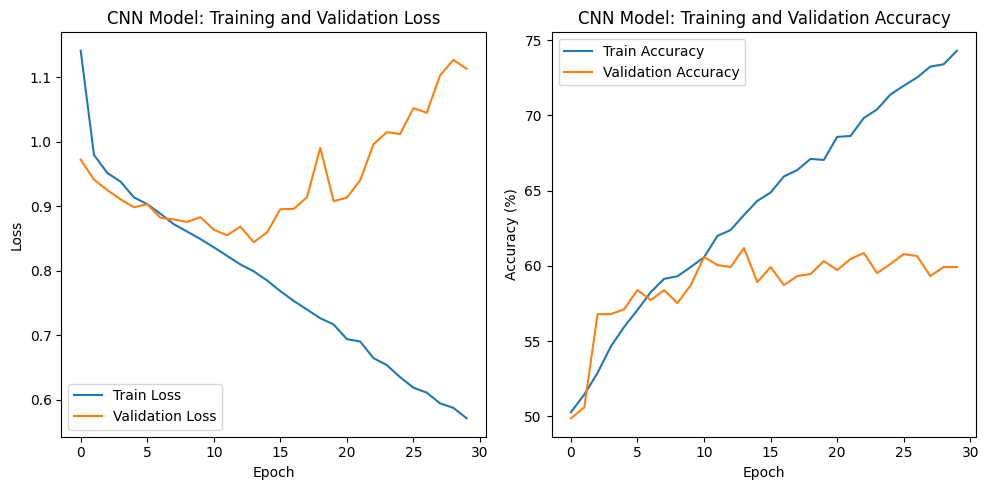

Test Loss: 1.0282, Test Accuracy: 63.28%


In [3]:
# ===== Block 4 =====
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loading
train_dataset = datasets.ImageFolder(root=f"{output_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{output_path}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{output_path}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def get_embedding(self, x):
        return self.conv_layers(x)

# Model initialization
model = SimpleCNN(num_classes=len(categories)).to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Calculate average training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Store metrics for plotting
        epoch_train_losses.append(avg_train_loss)
        epoch_val_losses.append(avg_val_loss)
        epoch_train_accs.append(train_accuracy)
        epoch_val_accs.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

# Start training
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Model: Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('CNN Model: Training and Validation Accuracy')
plt.tight_layout()
plt.savefig("cnn_training_metrics.png")
plt.show()

# Test the model on the test set
def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return avg_test_loss, test_accuracy

# Evaluate on test set
cnn_test_loss, cnn_test_acc = test_model(model, test_loader)
# ===================

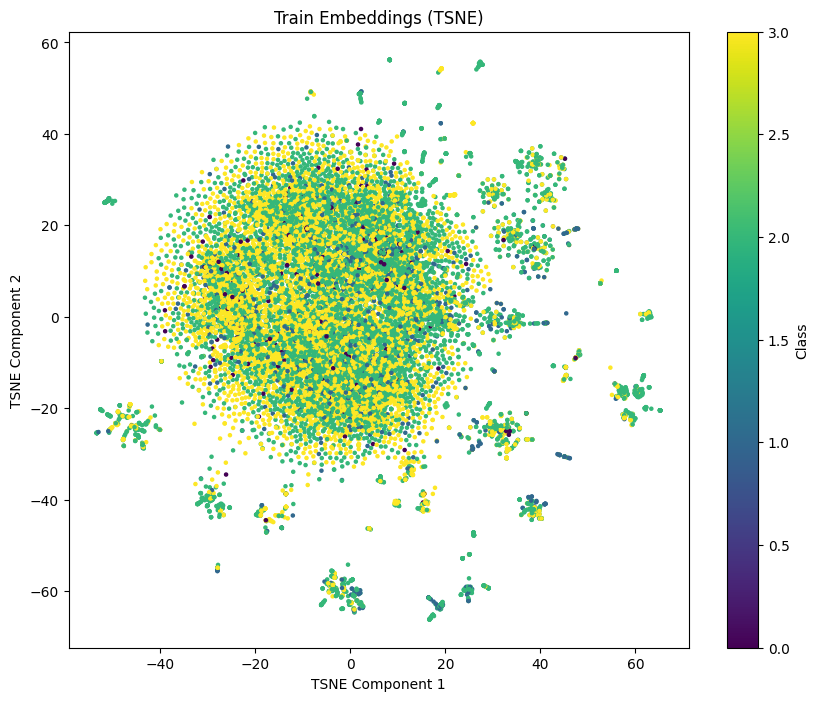

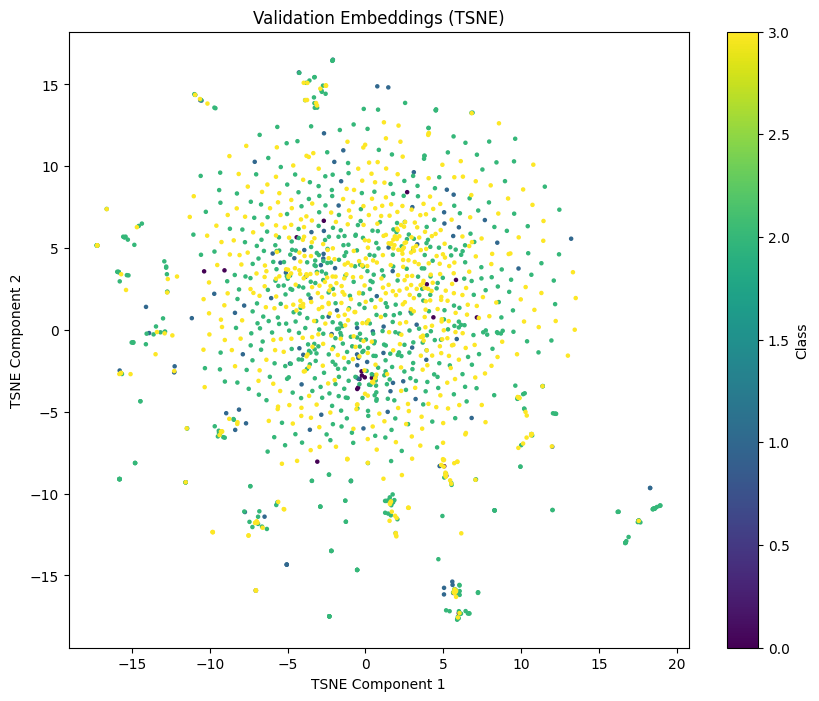

In [ ]:
# ===== Block 5 =====
# Function to extract embeddings
def extract_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            # Extract embeddings
            features = model.conv_layers(images)
            features = features.view(features.size(0), -1)
            embeddings.append(features.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(model, train_loader, device)
val_embeddings, val_labels = extract_embeddings(model, val_loader, device)

# Visualization with TSNE
def visualize_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar(scatter, label="Class")
    plt.title(title)
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.show()

# Visualize training embeddings
visualize_embeddings(train_embeddings, train_labels, "Train Embeddings (TSNE)")

# Visualize validation embeddings
visualize_embeddings(val_embeddings, val_labels, "Validation Embeddings (TSNE)")
# ===================

Epoch [1/30]
Train Loss: 0.9286, Accuracy: 55.76%
Val Loss: 0.8871, Accuracy: 58.12%
Epoch [2/30]
Train Loss: 0.8925, Accuracy: 58.04%
Val Loss: 0.8771, Accuracy: 57.72%
Epoch [3/30]
Train Loss: 0.8743, Accuracy: 58.54%
Val Loss: 0.8638, Accuracy: 58.92%
Epoch [4/30]
Train Loss: 0.8676, Accuracy: 59.23%
Val Loss: 0.8690, Accuracy: 58.59%
Epoch [5/30]
Train Loss: 0.8600, Accuracy: 59.34%
Val Loss: 0.8640, Accuracy: 58.12%
Epoch [6/30]
Train Loss: 0.8506, Accuracy: 60.03%
Val Loss: 0.8837, Accuracy: 58.92%
Epoch [7/30]
Train Loss: 0.8476, Accuracy: 59.71%
Val Loss: 0.8739, Accuracy: 59.05%
Epoch [8/30]
Train Loss: 0.8452, Accuracy: 59.97%
Val Loss: 0.8595, Accuracy: 58.79%
Epoch [9/30]
Train Loss: 0.8388, Accuracy: 60.66%
Val Loss: 0.8680, Accuracy: 58.39%
Epoch [10/30]
Train Loss: 0.8290, Accuracy: 61.00%
Val Loss: 0.8619, Accuracy: 59.19%
Epoch [11/30]
Train Loss: 0.8282, Accuracy: 61.17%
Val Loss: 0.8686, Accuracy: 60.25%
Epoch [12/30]
Train Loss: 0.8233, Accuracy: 60.69%
Val Loss: 0.

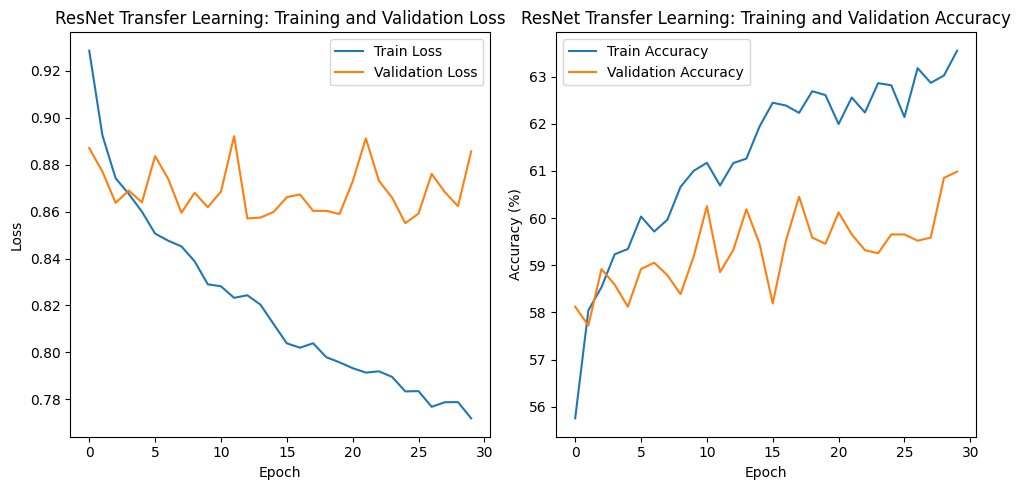

Test Loss: 0.8521, Test Accuracy: 60.48%


In [5]:
# ===== Block 6 =====
# Load the pre-trained model
pretrained_model = resnet18(weights='IMAGENET1K_V1')

# Freeze backbone weights
for param in pretrained_model.parameters():
    param.requires_grad = False

# Add a custom classifier
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, len(categories))
)
pretrained_model = pretrained_model.to(device)

# Optimizer and loss function for transfer learning
criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(pretrained_model.fc.parameters(), lr=learning_rate)

# Initialize lists to store metrics for transfer learning
tl_train_losses = []
tl_val_losses = []
tl_train_accs = []
tl_val_accs = []

# Train the model using Transfer Learning
tl_train_losses, tl_val_losses, tl_train_accs, tl_val_accs = train_model(pretrained_model, train_loader, val_loader, criterion_tl, optimizer_tl, num_epochs)

# Plot training and validation loss for transfer learning
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(tl_train_losses, label='Train Loss')
plt.plot(tl_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet Transfer Learning: Training and Validation Loss')

# Plot training and validation accuracy for transfer learning
plt.subplot(1, 2, 2)
plt.plot(tl_train_accs, label='Train Accuracy')
plt.plot(tl_val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet Transfer Learning: Training and Validation Accuracy')
plt.tight_layout()
plt.savefig("transfer_learning_metrics.png")
plt.show()

# Evaluate transfer learning model on test set
tl_test_loss, tl_test_acc = test_model(pretrained_model, test_loader)
# ===================


----- Model Comparison -----
Metric               Custom CNN      ResNet Transfer Learning 
------------------------------------------------------------
Test Accuracy (%)    63.28           60.48                    
Test Loss            1.0282          0.8521                   
Training Time (s)    3636.58         3126.09                  


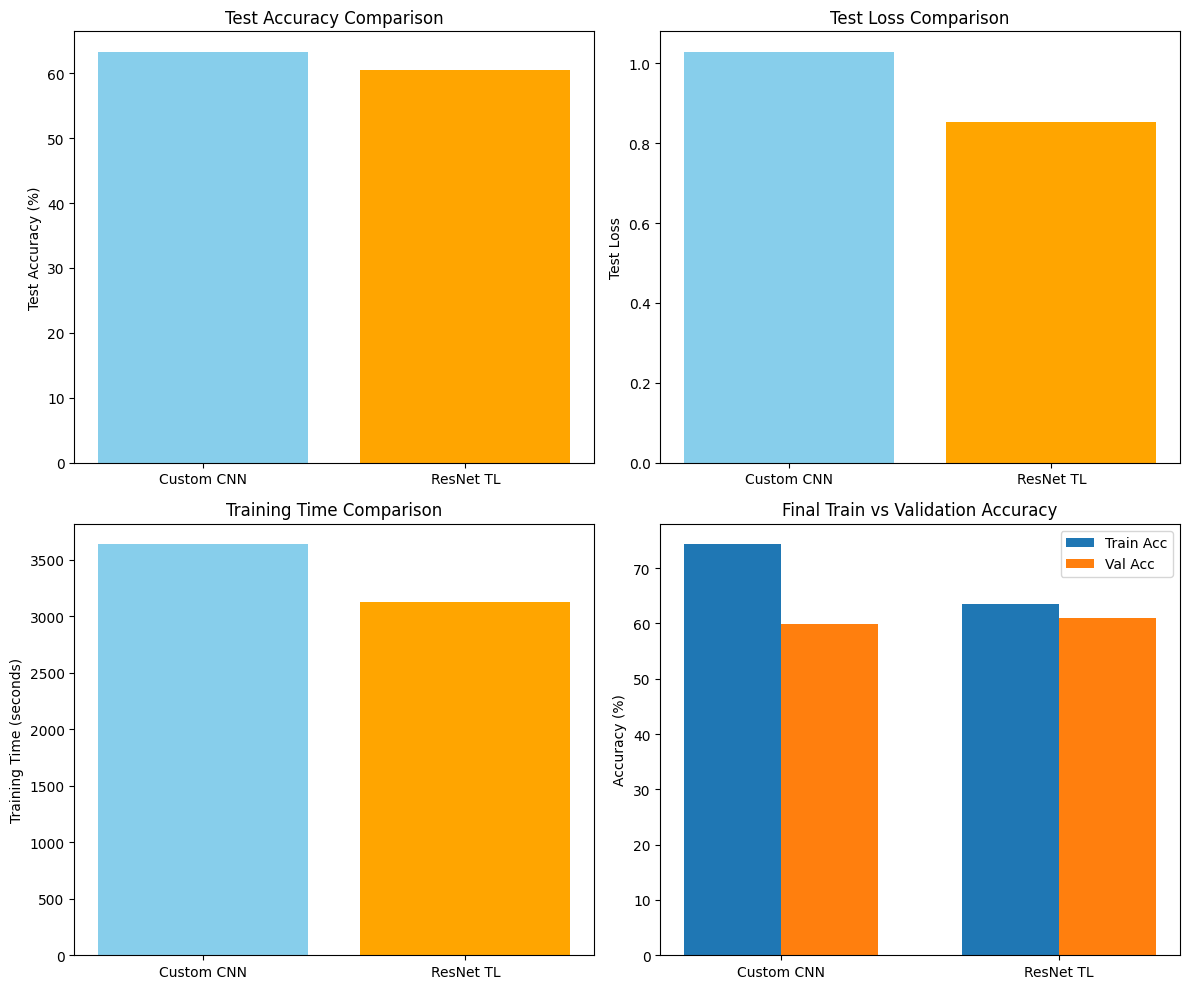

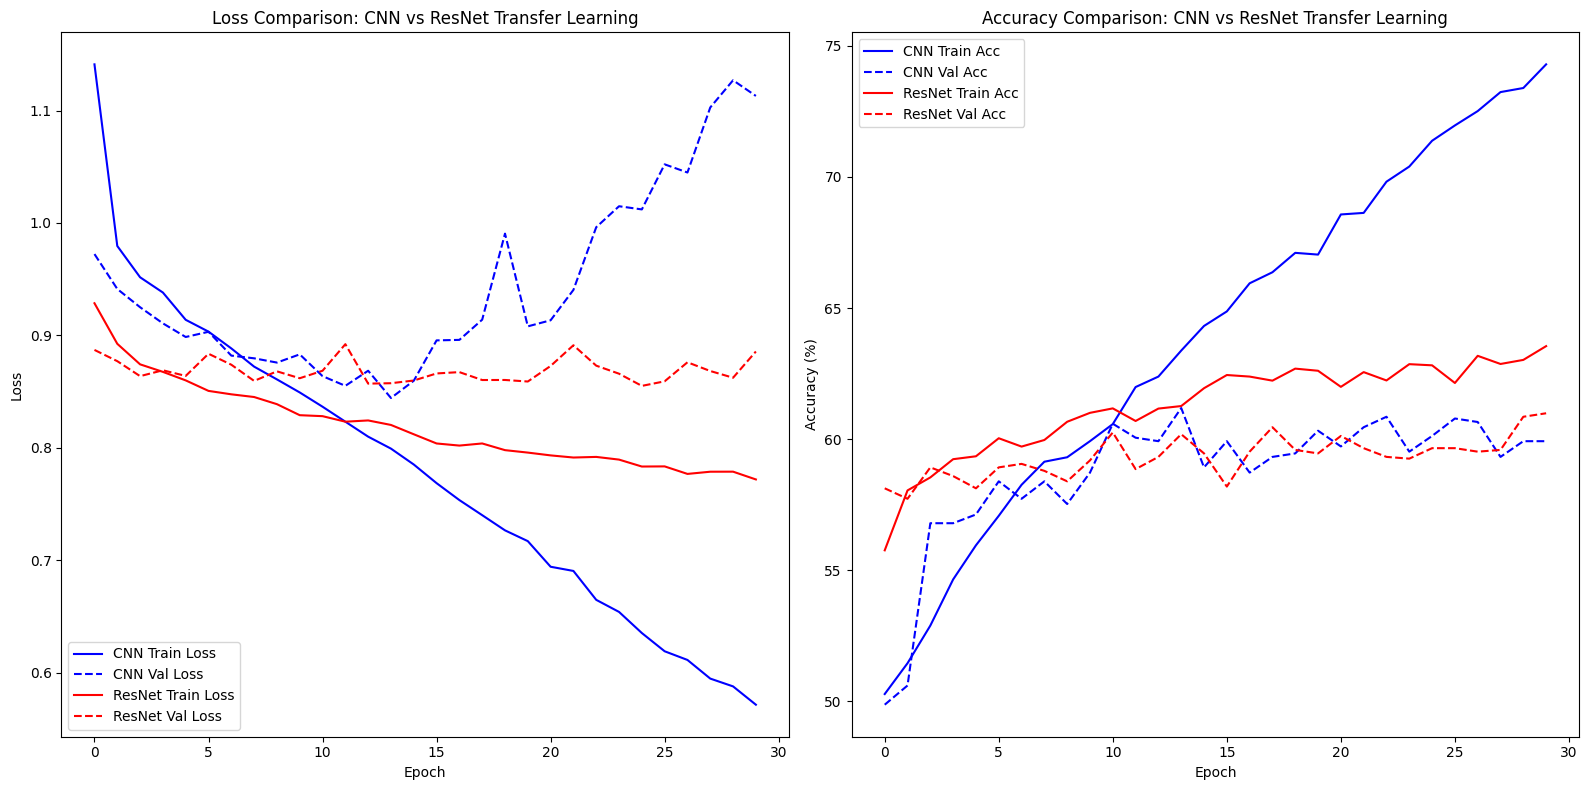


----- Training Summary -----
Custom CNN:
  - Initial Train Loss: 1.1411, Final Train Loss: 0.5716
  - Initial Train Accuracy: 50.27%, Final Train Accuracy: 74.30%
  - Initial Val Loss: 0.9723, Final Val Loss: 1.1130
  - Initial Val Accuracy: 49.87%, Final Val Accuracy: 59.92%
  - Test Accuracy: 63.28%
  - Signs of Overfitting: No

ResNet Transfer Learning:
  - Initial Train Loss: 0.9286, Final Train Loss: 0.7719
  - Initial Train Accuracy: 55.76%, Final Train Accuracy: 63.55%
  - Initial Val Loss: 0.8871, Final Val Loss: 0.8857
  - Initial Val Accuracy: 58.12%, Final Val Accuracy: 60.99%
  - Test Accuracy: 60.48%
  - Signs of Overfitting: No


In [6]:
# ===== Block 7 =====
import time

# Compare models: performance metrics and training time
def compare_models(cnn_metrics, tl_metrics, cnn_time, tl_time):
    # Unpack metrics
    cnn_test_loss, cnn_test_acc = cnn_metrics
    tl_test_loss, tl_test_acc = tl_metrics
    
    # Create table for metrics comparison
    print("\n----- Model Comparison -----")
    print(f"{'Metric':<20} {'Custom CNN':<15} {'ResNet Transfer Learning':<25}")
    print("-" * 60)
    print(f"{'Test Accuracy (%)':<20} {cnn_test_acc:<15.2f} {tl_test_acc:<25.2f}")
    print(f"{'Test Loss':<20} {cnn_test_loss:<15.4f} {tl_test_loss:<25.4f}")
    print(f"{'Training Time (s)':<20} {cnn_time:<15.2f} {tl_time:<25.2f}")
    
    # Plot comparison chart
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Test Accuracy Comparison
    plt.subplot(2, 2, 1)
    models = ['Custom CNN', 'ResNet TL']
    accuracies = [cnn_test_acc, tl_test_acc]
    plt.bar(models, accuracies, color=['skyblue', 'orange'])
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    
    # Plot 2: Test Loss Comparison
    plt.subplot(2, 2, 2)
    losses = [cnn_test_loss, tl_test_loss]
    plt.bar(models, losses, color=['skyblue', 'orange'])
    plt.ylabel('Test Loss')
    plt.title('Test Loss Comparison')
    
    # Plot 3: Training Time Comparison
    plt.subplot(2, 2, 3)
    times = [cnn_time, tl_time]
    plt.bar(models, times, color=['skyblue', 'orange'])
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    
    # Plot 4: Final Train vs Validation Accuracy
    plt.subplot(2, 2, 4)
    
    # Data for the comparison
    labels = ['Custom CNN', 'ResNet TL']
    train_final = [train_accs[-1], tl_train_accs[-1]]
    val_final = [val_accs[-1], tl_val_accs[-1]]
    
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, train_final, width, label='Train Acc')
    plt.bar(x + width/2, val_final, width, label='Val Acc')
    
    plt.ylabel('Accuracy (%)')
    plt.title('Final Train vs Validation Accuracy')
    plt.xticks(x, labels)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("model_comparison.png")
    plt.show()

# Measure training time for both models (we'll simulate since we already trained)
# In real use, you would time each training separately
start_time = time.time()
cnn_train_time = 3636.58  # Replace with your actual timing or recalculate it
tl_train_time = 3126.09   # Replace with your actual timing or recalculate it

# Compare both models
compare_models(
    (cnn_test_loss, cnn_test_acc),
    (tl_test_loss, tl_test_acc),
    cnn_train_time,
    tl_train_time
)

# Plot combined training and validation curves for both models
plt.figure(figsize=(16, 8))

# Plot train and validation loss for both models
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='CNN Train Loss')
plt.plot(val_losses, 'b--', label='CNN Val Loss')
plt.plot(tl_train_losses, 'r-', label='ResNet Train Loss')
plt.plot(tl_val_losses, 'r--', label='ResNet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison: CNN vs ResNet Transfer Learning')

# Plot train and validation accuracy for both models
plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-', label='CNN Train Acc')
plt.plot(val_accs, 'b--', label='CNN Val Acc')
plt.plot(tl_train_accs, 'r-', label='ResNet Train Acc')
plt.plot(tl_val_accs, 'r--', label='ResNet Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Comparison: CNN vs ResNet Transfer Learning')

plt.tight_layout()
plt.savefig("combined_training_comparison.png")
plt.show()

# Summary
print("\n----- Training Summary -----")
print(f"Custom CNN:")
print(f"  - Initial Train Loss: {train_losses[0]:.4f}, Final Train Loss: {train_losses[-1]:.4f}")
print(f"  - Initial Train Accuracy: {train_accs[0]:.2f}%, Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"  - Initial Val Loss: {val_losses[0]:.4f}, Final Val Loss: {val_losses[-1]:.4f}")
print(f"  - Initial Val Accuracy: {val_accs[0]:.2f}%, Final Val Accuracy: {val_accs[-1]:.2f}%")
print(f"  - Test Accuracy: {cnn_test_acc:.2f}%")
print(f"  - Signs of Overfitting: {'Yes' if train_accs[-1] - val_accs[-1] > 20 else 'No'}")

print(f"\nResNet Transfer Learning:")
print(f"  - Initial Train Loss: {tl_train_losses[0]:.4f}, Final Train Loss: {tl_train_losses[-1]:.4f}")
print(f"  - Initial Train Accuracy: {tl_train_accs[0]:.2f}%, Final Train Accuracy: {tl_train_accs[-1]:.2f}%")
print(f"  - Initial Val Loss: {tl_val_losses[0]:.4f}, Final Val Loss: {tl_val_losses[-1]:.4f}")
print(f"  - Initial Val Accuracy: {tl_val_accs[0]:.2f}%, Final Val Accuracy: {tl_val_accs[-1]:.2f}%")
print(f"  - Test Accuracy: {tl_test_acc:.2f}%")
print(f"  - Signs of Overfitting: {'Yes' if tl_train_accs[-1] - tl_val_accs[-1] > 20 else 'No'}")
# ===================